# Portfolio Optimization


## Stock data
Data from Brazil stock market

In [1]:
from statsmodels.tsa.arima_model import ARIMA
import networkx as nx
import random as rd
import matplotlib.pyplot as plt
import gurobipy as gp
import seaborn as sns
import pandas as pd
import numpy as np
from gurobipy import GRB
from math import sqrt


class InvestorOpt:
    """Class that implements a optimization machine for investors"""
    
    def __init__(self, excel_file = None, dataframe = None, min_allocation=None, use_model_for_risk = False):
        """Read a excel file or pandas dataframe"""
        if excel_file is None:
            self._read_data_frame(dataframe)
        else:
            self._read_excel(excel_file)
        self._use_model_for_risk = use_model_for_risk
        self._create_model(min_allocation)
        self._minrisk_volatility = sqrt(self._m.ObjVal)
        self._portfolio_return = self._stock_return.dot(self._x)
        self._minrisk_return = self._portfolio_return.getValue()
        self._min_risk_allocation = self._get_formated_df(self._x, 
                                                          self._minrisk_volatility, 
                                                          self._portfolio_return)
        
    def __str__(self):
        return str(f'Portfolio Summary:\
            \n\tStocks list: {self._stocks}\
            \n\tMin return: {self._stock_return.min()}\
            \n\tMax return: {self._stock_return.max()}\
            \n\tCovariance Matrix: {self._sigma}\
            ')
    
    def get_formatted_cov(self):
        cov = self._original_data.cov()
        return self._get_formated_matrix(cov)
    
    def get_formatted_corr(self, vmin=None):
        cor = self._original_data.corr()
        return self._get_formated_matrix(cor)
    
    def _get_formated_matrix(self, matrix):
        sns.set(style="white")
        # Compute the covariation matrix
        
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(matrix, dtype=np.bool))
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(7, 5))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(10, 220, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(matrix, mask=mask, cmap=cmap, vmax=matrix.max().max(), vmin=matrix.min().min(), center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})        
        return pd.DataFrame(data=matrix, columns=self._stocks, index=self._stocks)
    
        
    def _read_data_frame(self, data):
        self._original_data = data
        self._reldiff = np.transpose(data.values)
        self._sigma = np.cov(self._reldiff)
        self._stocks = data.columns.to_list()
        
    def _read_excel(self, file):
        if type(file)==str:
            data = pd.read_excel(file, sheet_name='Series')
            self._read_data_frame(data)
        else:
            raise TypeError('Provided excel file is not valid.')
    
    def get_max_return(self):
        return self._stock_return.max()
    
    def get_min_return(self):
        return self._stock_return.min()
    
    def get_min_risk_allocation(self):
        return self._min_risk_allocation
    
    def _get_model_error(self, serie):
        len_ = int(serie.shape[0]/2)
        train_ = serie[0:len_+1]
        test_ = serie[-len_:]
        model = ARIMA(train_, order=(5,1,0))
        model_fit = model.fit(disp=0)
        history=train_
        err_list = []
        for t in range(test_.shape[0]):
            model = ARIMA(history, order=(5,1,0))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0][0]
            err = ((test_.values[t]-yhat)**2)**0.5
            err_list.append(err)
            history = serie[t:len_+1+t]
        return np.mean(err_list)
    
    def _get_risk(self):
        if self._use_model_for_risk:
            err = []
            for s in self._stocks:
                err.append(self._get_model_error(self._original_data[s]))
            return np.array(err)
        else:
            return np.std(self._reldiff, axis=1) # standard deviation
    
    def _create_model(self, min_allocation):
        def _min_perc(s):
            M = 101
            return (self._y.loc[s]*M >= self._x.loc[s])
            
        # Calculate basic summary statistics for individual stocks
        self._stock_volatility = self._get_risk()
        self._stock_return = np.mean(self._reldiff, axis=1)    # mean

        # Create an model
        self._m = gp.Model('Portfolio')
        self._m.setParam('OutputFlag', 0)

        # Add matrix variable for the stocks
        #self._x = self._m.addMVar(len(self._stocks),name=self._stocks)
        self._x = pd.Series(self._m.addVars(self._stocks,name=self._stocks), index=self._stocks)


        # Objective is to minimize risk (squared).  This is modeled using the
        # covariance matrix, which measures the historical correlation between stocks
        #print(self._sigma)
        
        self._portfolio_risk = self._sigma.dot(self._x).dot(self._x)
        #print(self._portfolio_risk)
        self._m.setObjective(self._portfolio_risk, GRB.MINIMIZE)

        # Fix budget with a constraint
        self._m.addConstr(self._x.sum() == 1, 'budget')
        
        if min_allocation:
            self._y = pd.Series(self._m.addVars(self._stocks, vtype= GRB.BINARY, lb=0), index=self._stocks)
            self._m.addConstrs((_min_perc(s) for s in self._stocks), name='minimum')
            for s in self._stocks:
                self._m.addGenConstrIndicator(self._y.loc[s], True, self._x.loc[s] >= min_allocation)
        #Fix return
        #m.addConstr(sum(x.vararr*stock_return)==0.7, 'target_return')

        # Optimize model to find the minimum risk portfolio
        self._m.optimize()
        #self._m.write('portfolio.lp')
        #print(self._y.X)
        #print(self._x.X)
        
    def _get_objval(self):
        if self._m.status == GRB.OPTIMAL:
            return max(self._m.ObjVal,0)
        
    def compute_efficient_frontier(self, target_return):
        """Target return is a fixed rate to persuit"""
        # Create an expression representing the expected return for the portfolio
        #self._portfolio_return = self._stock_return @ self._x
        self._portfolio_return = self._stock_return.dot(self._x)
        target = self._m.addConstr(self._portfolio_return == self._minrisk_return, 'target')

        # Solve for efficient frontier by varying target return
        self._frontier = np.empty((2,0))
        printed = False
        for r in np.linspace(self._stock_return.min(), self._stock_return.max(), 25):
            target.rhs = r
            self._m.optimize()
            self._frontier = np.append(self._frontier, [[sqrt(self._get_objval())],[r]], axis=1)
            if (r > target_return) & (~printed):
                volatility = sqrt(self._get_objval())
                port_return = self._stock_return.dot(self._x)
                good_return = self._get_formated_df(self._x, volatility, port_return)
                printed = True
        return good_return
        
    def _get_formated_df(self, x, volatility, port_return):
        return pd.DataFrame(data=np.append([i.x for i in x], 
                                                          [volatility, port_return.getValue()]),
                     index=self._stocks+ ['Volatility', 'Expected Return'],
                     columns=['Set Risk Portfolio'])
    
    def plot_efficient_frontier(self, perc_target_return=0.75):
        """Plot eficient frontier (Markowitz)"""
        good_return = self.compute_efficient_frontier(perc_target_return)
        fig, ax = plt.subplots(figsize=(12,10))
        #ax = plt.gca()

        # Plot volatility versus expected return for individual stocks
        ax.scatter(x=self._stock_volatility, y=self._stock_return,
                   color='Blue', label='Individual Stocks')
        for i, stock in enumerate(self._stocks):
            ax.annotate(stock, (self._stock_volatility[i], self._stock_return[i]))

        # Plot volatility versus expected return for minimum risk portfolio
        ax.scatter(x=self._minrisk_volatility, y=self._minrisk_return, color='DarkGreen')
        ax.annotate('Minimum\nRisk\nPortfolio', (self._minrisk_volatility, self._minrisk_return),
                    horizontalalignment='right')

        # Plot efficient frontier
        ax.plot(self._frontier[0], self._frontier[1], label='Efficient Frontier', color='DarkGreen')

        # Format and display the final plot
        #ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, stock_return.min()*1.2, stock_return.max()*1.2])
        ax.set_xlabel('Volatility (standard deviation)')
        ax.set_ylabel('Expected Return')
        ax.legend()
        ax.grid()
        plt.show()
        return good_return
    
    def plot_graph(self, thresold = 0.5):
        cov_G = nx.Graph()
        thresold = 0.5
        edge_labels = {}
        for col in df_cov.columns:
            cov_G.add_node(col)
            for ed in df_cov.columns:
                if abs(df_cor.loc[col,ed])>thresold:
                    cov_G.add_edge(col, ed, weight=df_cor.loc[col,ed]/5)
                    edge_labels[tuple((col,ed))]="{:.2f}".format(df_cor.loc[col,ed])

        pos = nx.spring_layout(cov_G)
        plt.figure(figsize=(6,6))
        nx.draw(cov_G,pos,edge_color='black',width=1,linewidths=1,\
                node_size=500,node_color='pink',alpha=0.9,\
                labels={node:node for node in cov_G.nodes()})

        nx.draw_networkx_edge_labels(cov_G,pos,edge_labels=edge_labels,
                                     font_color='red',font_size=12)
        plt.axis('off')
        plt.show()

    
def simulate_investment(df, allocate_each = 12, target = None, 
                        use_model_for_risk = False, min_allocation=0.01, baseline='CDI'):
    """Target default is minimum risk"""
    cycles = int(df.shape[0]/allocate_each)
    eps = 0.001
    train = True
    total_return_list = []
    expected_return_list = []
    baseline_return_list = []
    allocation_dict = {}
    data_dict = {}
    i = 0
    data = df.iloc[0:allocate_each,:]
    while i<cycles:
        if train:            
            model = InvestorOpt(dataframe=data, min_allocation=0.01, use_model_for_risk = use_model_for_risk)
            if target is None:
                allocation_df = model.get_min_risk_allocation()
            else:
                use_target = target
                if model.get_max_return() < use_target:
                    use_target = model.get_max_return()-eps
                allocation_df = model.compute_efficient_frontier(use_target)
            train = False
        else:
            i = i + 1
            next_ = i*allocate_each
            data = df.iloc[0+next_:allocate_each+next_,:]
            
            train = True
            stock_return = (data/100+1).prod()-1 #data.mean()
            total_return = allocation_df.iloc[:,0].multiply(stock_return).sum()
            expected_return = (allocation_df.loc['Expected Return'].values[0]/100+1)**allocate_each -1
            total_return_list.append(total_return)
            expected_return_list.append(expected_return)
            baseline_return_list.append(stock_return[baseline])
            allocation_dict[i] = allocation_df
            data_dict[i] = data
    
    consolidated = pd.DataFrame()
    consolidated['Real Return'] = pd.Series(data=total_return_list)
    consolidated['Forcasted Return'] = pd.Series(data=expected_return_list)
    consolidated['Baseline Return'] = pd.Series(data=baseline_return_list)
    
    return consolidated, allocation_dict, data_dict

def get_my_data():
    stocks = ['CDI', 'IBOVESPA', 'IPCA', 'Dolar', 'Poupanca', 'Boi', 'Ouro']#'SELIC'
    data = pd.read_excel('./series_financeiras.xlsx', sheet_name='Series')
    data = data[stocks]
    data['IPCA+4'] = data['IPCA'] + (1.04**(1/12)-1)*100 #IPCA + 4% ao ano
    
    stocks = ['CDI', 'IBOVESPA', 'IPCA+4', 'Dolar', 'Poupanca', 'Boi', 'Ouro']
    return data[stocks]

In [ ]:
x = []
x1 = []
y = []
y2 = []
allocation = {}
max_ = 30
allocate_each = 12
df = get_my_data()
for i in range(max_):
    target = i/max_
    try:
        result, allocation_dict, data_dict = simulate_investment(df, allocate_each = allocate_each, target = target, 
                                                      use_model_for_risk = False, min_allocation=0.01, 
                                                      baseline='CDI')
        #print(result)
        y.append((result['Real Return']+1).prod()-1)
        x.append((result['Forcasted Return']+1).prod()-1)
        y2.append((result['Baseline Return']+1).prod()-1)
        x1.append(target)
        allocation[str(target)] = allocation_dict
    except UnboundLocalError:
        print('Not possible to calculate portfolio for', str(target))
    
plt.scatter(x1,y,c='blue')
plt.plot(x1,y2,c='red')
plt.show()

In [3]:
#allocation.keys()
#allocation_dict[1]
#allocation['0.7'][22]

dict_keys(['0.0', '0.03333333333333333', '0.06666666666666667', '0.1', '0.13333333333333333', '0.16666666666666666', '0.2', '0.23333333333333334', '0.26666666666666666', '0.3', '0.3333333333333333', '0.36666666666666664', '0.4', '0.43333333333333335', '0.4666666666666667', '0.5', '0.5333333333333333', '0.5666666666666667', '0.6', '0.6333333333333333', '0.6666666666666666', '0.7', '0.7333333333333333', '0.7666666666666667', '0.8', '0.8333333333333334', '0.8666666666666667', '0.9', '0.9333333333333333', '0.9666666666666667'])

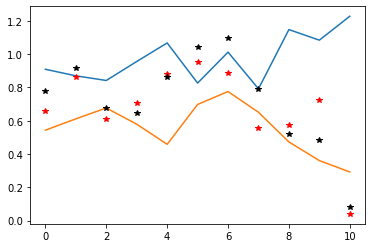

In [4]:
target = '0.8333333333333334'
result, allocation_dict, data_dict = simulate_investment(df, allocate_each = allocate_each, target = 0.72, 
                                                      use_model_for_risk = False, min_allocation=0.01, 
                                                      baseline='CDI')

volat = [allocation_dict[i].loc['Volatility'].values[0] for i in allocation_dict]
ret = [allocation_dict[i].loc['Expected Return'].values[0] for i in allocation_dict]
sup = [r + 2*v for r, v in zip(ret, volat)]
inf = [r - 2*v for r, v in zip(ret, volat)]
plt.plot(sup,)
plt.plot(inf)
plt.plot(((result['Real Return']+1)**(1/12)-1)*100,'r*')
plt.plot(((result['Baseline Return']+1)**(1/12)-1)*100,'k*')

In [5]:
#data_dict[1]
#allocation_dict[1]
#print(allocation_dict[1])

c:\users\rodrigo\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\rodrigo\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


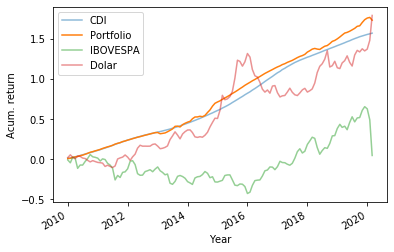

In [7]:
target = 0.8333333333333334
target_str = str(target)
baseline = 'CDI'
baseline2 = 'IBOVESPA'
baseline3 = 'Dolar'
result, allocation_dict, data_dict = simulate_investment(df, allocate_each = allocate_each, target = target, 
                                              use_model_for_risk = False, min_allocation=0.01, 
                                              baseline=baseline)

def get_port_result(row,i):
    _sum = 0
    for s in allocation_dict[i].iloc[:-2].index.to_list():
        _sum = _sum + row.loc[s]*allocation_dict[i].loc[s].values[0]
    return _sum

df_data = pd.DataFrame()
for i in allocation[target_str]:
    data_dict[i]['Portfolio'] = data_dict[i].apply(lambda x: get_port_result(x,i), axis=1)
    if i == 1:
        df_data = data_dict[i]
    else:
        df_data = df_data.append(data_dict[i])

import datetime
from dateutil.relativedelta import *
def get_date(row):
    index = row.name
    start = datetime.datetime(2009, 1, 1, 0, 0)
    dif = relativedelta(months=+1)
    data = start + dif*(index)
    return data

df_data['date'] = df_data.apply(get_date, axis=1)

fig, ax = plt.subplots()
fig.autofmt_xdate()
#ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.plot(df_data['date'],(df_data[baseline]/100+1).cumprod()-1, label=baseline, alpha=0.5)
plt.plot(df_data['date'],(df_data['Portfolio']/100+1).cumprod()-1, label='Portfolio')
plt.plot(df_data['date'],(df_data[baseline2]/100+1).cumprod()-1, label=baseline2, alpha=0.5)
plt.plot(df_data['date'],(df_data[baseline3]/100+1).cumprod()-1, label=baseline3, alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Acum. return')
plt.legend()
plt.show()

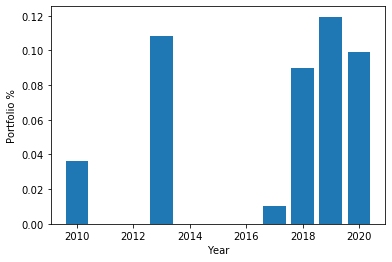

In [8]:
serie = 'IBOVESPA'
years = []
series = []
for year in range(2010,2021):
    index = year - 2009
    series.append(allocation_dict[index].loc[serie][0])
    years.append(year)
plt.bar(height=series,x=years)
plt.xlabel('Year')
plt.ylabel('Portfolio %')
plt.show()
#print(series)

MAX: 1.5107111689314914
MIN: -0.06605257040254064


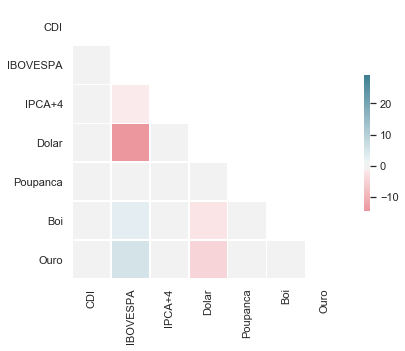

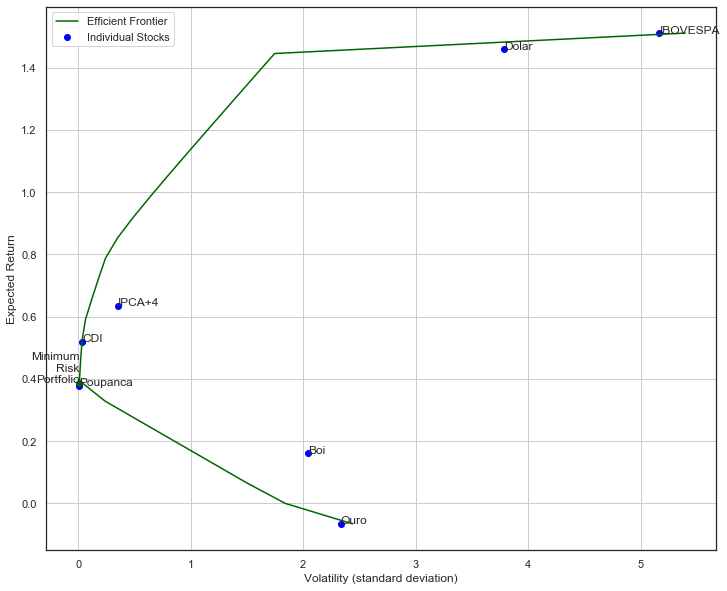

In [9]:
df = get_my_data().iloc[108:120]#only 2019
model = InvestorOpt(dataframe=df, min_allocation=0.01, use_model_for_risk = False)
print('MAX:', model.get_max_return())
print('MIN:', model.get_min_return())
model.get_formatted_cov()
df_alocacao_08 = model.plot_efficient_frontier(model.get_max_return()*0.3)

In [10]:
#print(model)
model.get_min_risk_allocation()

,Set Risk Portfolio
CDI,0.072506
IBOVESPA,0.000000
IPCA+4,0.000000
Dolar,0.000000
Poupanca,0.927494
Boi,0.000000
Ouro,0.000000
Volatility,0.010718
Expected Return,0.387602


In [11]:
df_alocacao_08

,Set Risk Portfolio
CDI,0.554088
IBOVESPA,0.000000
IPCA+4,0.014060
Dolar,0.000000
Poupanca,0.431852
Boi,0.000000
Ouro,0.000000
Volatility,0.021387
Expected Return,0.459535


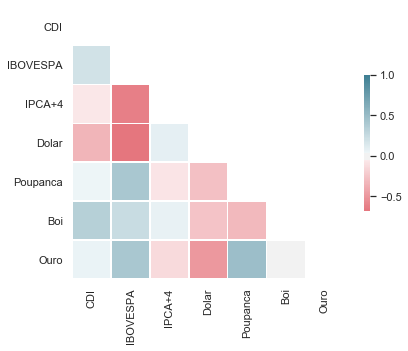

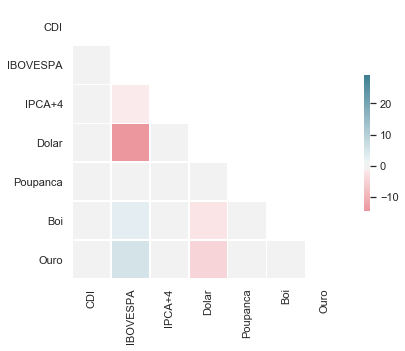

In [16]:
df_cor = model.get_formatted_corr()
df_cov = model.get_formatted_cov()

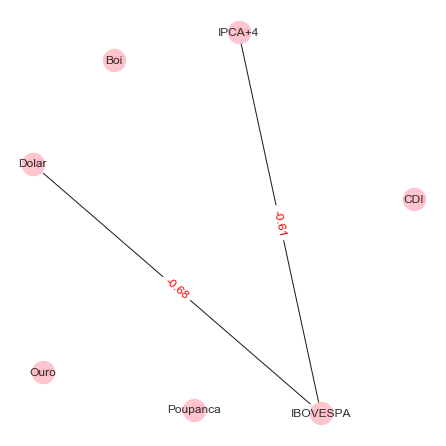

In [17]:
model.plot_graph()
#nx.draw(cov_G, with_labels=True, font_size=14, node_size=400, 
#        arrows=True, edge_vmin = thresold, edge_vmax=1, 
#        edge_cmap='inferno',linewidths=3)

,CDI,IBOVESPA,IPCA+4,Dolar,Poupanca,Boi,Ouro
CDI,1.000000,0.195554,-0.060273,-0.330402,0.044249,0.346283,0.057523
IBOVESPA,0.195554,1.000000,-0.614086,-0.676457,0.410829,0.245288,0.421012
IPCA+4,-0.060273,-0.614086,1.000000,0.091004,-0.071511,0.072855,-0.127444
Dolar,-0.330402,-0.676457,0.091004,1.000000,-0.265198,-0.255821,-0.485073
Poupanca,0.044249,0.410829,-0.071511,-0.265198,1.000000,-0.304466,0.487002
Boi,0.346283,0.245288,0.072855,-0.255821,-0.304466,1.000000,-0.000592
Ouro,0.057523,0.421012,-0.127444,-0.485073,0.487002,-0.000592,1.000000


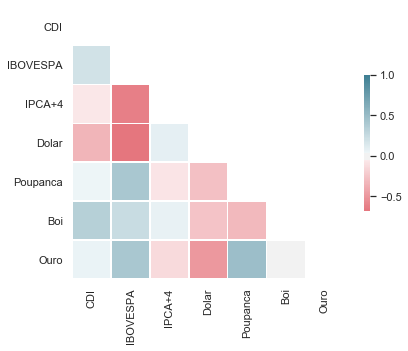

In [18]:
df_cov = model.get_formatted_corr()
df_cov

### Com dados IBOVESPA

In [19]:
data_2019 = pd.read_excel('./COTAHIST_A2019.xlsx')
data_2020 = pd.read_excel('./COTAHIST_A2020.xlsx')
cols = ['Data','Papel','Fechamento']

In [20]:
stocks = pd.read_csv('./papeis.csv', sep=';',encoding='UTF-8',header=None)
stocks = stocks[0].values.tolist()
stocks.remove('CESP5')

In [21]:
data_2020['Data'] = pd.to_datetime(data_2020['Data'], yearfirst=True, format='%Y%m%d')
data_2019['Data'] = pd.to_datetime(data_2019['Data'], yearfirst=True, format='%Y%m%d')
data_ibo = data_2019[cols].append(data_2020[cols])
data_ibo = data_ibo.loc[data_ibo.Papel.isin(stocks)]
data_ibo.loc[data_ibo.Papel=='VALE3'].tail()

,Data,Papel,Fechamento
383540,2020-05-15,VALE3,48.05
389083,2020-05-18,VALE3,51.25
393214,2020-05-19,VALE3,52.40
397077,2020-05-20,VALE3,52.50
401236,2020-05-21,VALE3,51.10


In [22]:
data_ibo['mes'] = data_ibo.Data.dt.month
data_ibo['ano'] = data_ibo.Data.dt.year
data_ibo['mes'] = data_ibo.mes.apply(str)
data_ibo['ano'] = data_ibo.ano.apply(str)

data_ibo.sort_values(by='Data',inplace=True)
data_ibo = data_ibo.groupby(['Papel','mes','ano']).first().reset_index().sort_values(by='Data')
#pegando inicio do mês apenas
data_ibo['mes_ano'] = data_ibo['ano'] + data_ibo['mes'] 
data_ibo.loc[data_ibo.Papel=='VALE3'].head()

,Papel,mes,ano,Data,Fechamento,mes_ano
6531,VALE3,1,2019,2019-01-02,51.05,20191
6536,VALE3,2,2019,2019-02-01,46.23,20192
6538,VALE3,3,2019,2019-03-01,46.72,20193
6540,VALE3,4,2019,2019-04-01,52.59,20194
6542,VALE3,5,2019,2019-05-02,48.93,20195


In [23]:
data_stocks = data_ibo.pivot(index='mes_ano',columns='Papel',values='Fechamento')
data_stocks = data_stocks.dropna(axis=1).reset_index().drop(columns='mes_ano')
#data_stocks = data_stocks - data_stocks.iloc[0]
data_stocks = data_stocks.pct_change()*100 #percentual
data_stocks = data_stocks.replace(np.inf, 0)#np.nan)
data_stocks = data_stocks.replace(np.nan, 0)
#data_stocks.dropna(inplace=True, axis=1)

MAX: 275.8480437528025
MIN: -6.614900766591987


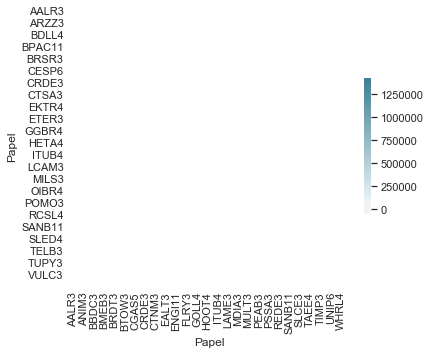

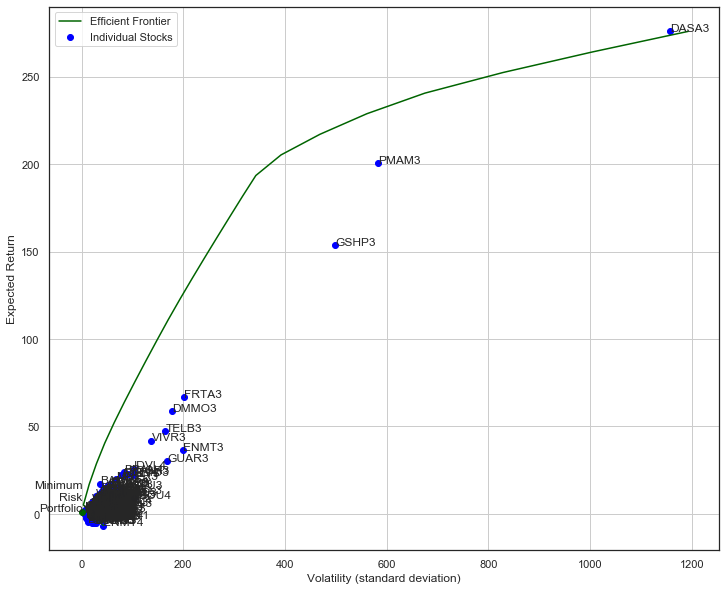

,Set Risk Portfolio
CEBR6,0.011246
CRPG6,0.087875
CSRN3,0.046439
ENMT3,0.013351
INEP3,0.034979
MGLU3,0.093439
RANI4,0.029958
REDE3,0.433372
RPAD6,0.186550
WLMM3,0.062791


In [24]:
model_ibo = InvestorOpt(dataframe=data_stocks.iloc[:,:], min_allocation=0.01, use_model_for_risk = False)
print('MAX:', model_ibo.get_max_return())
print('MIN:', model_ibo.get_min_return())
model_ibo.get_formatted_cov()
df_alocacao_ibo = model_ibo.plot_efficient_frontier(0.85)
df_alocacao_ibo.loc[df_alocacao_ibo['Set Risk Portfolio']>0]

In [26]:
data_subset = df_alocacao_ibo.tail(15).reset_index()
data_subset.drop(columns=['index'], inplace=True)
data_ibo_fix = data_subset.join(data_stocks)
data_ibo_fix = data_ibo_fix.iloc[1:15]

In [27]:
data_ibo_fix

,Set Risk Portfolio,AALR3,ABCB4,ABEV3,ADHM3,AFLT3,AGRO3,ALPA3,ALPA4,ALUP11,...,VLID3,VULC3,VVAR3,WEGE3,WHRL3,WHRL4,WIZS3,WLMM3,WLMM4,WSON33
1,0.000000,44.772727,3.225806,19.652821,26.573427,260.869565,12.327044,36.785714,46.853547,35.940011,...,-27.420227,8.606557,77.853881,34.649611,6.413302,-5.208333,57.284300,61.290323,56.854839,-13.784398
2,0.000000,-4.343276,5.284091,-10.207254,-15.469613,-15.361446,-5.319149,0.739774,7.830152,-3.191489,...,8.941878,1.383648,-2.053915,6.897976,36.607143,48.571429,-1.079137,4.000000,7.583548,8.345534
3,0.000000,1.367615,-0.593632,3.635314,-3.267974,-5.551601,0.295683,15.377970,12.572254,6.227106,...,-6.976744,-3.225806,20.052425,16.537867,14.052288,3.994083,16.363636,41.794872,43.488650,-1.891892
4,0.000000,-16.351862,7.003257,0.779510,-3.378378,-64.958553,-5.011792,-28.566080,-35.494223,-16.283525,...,52.205882,3.333333,-34.934498,-34.913793,-36.819484,-32.859175,-37.109375,-50.271248,-48.376353,13.856749
5,0.000000,1.290323,-7.762557,-7.127072,12.587413,0.430108,-1.303538,-0.157233,-2.039801,2.288330,...,-7.439614,-1.985112,-23.993289,-6.571574,-4.761905,-25.847458,10.807453,-45.272727,2.580645,0.774256
6,0.000000,-6.114650,6.875688,0.000000,-1.863354,8.779443,-0.566038,-18.005249,-21.889284,3.713647,...,0.313152,-14.430380,-5.960265,-1.526718,3.809524,31.428571,-4.035874,66.112957,4.245283,-8.163265
7,0.000000,0.000000,-0.772002,6.722189,-6.962025,-3.740157,-1.012018,-3.201024,1.560468,-1.251079,...,-8.428720,-9.023669,-2.816901,3.875969,2.981651,4.130435,-3.738318,-39.800000,-21.116139,1.960784
8,0.000000,-6.716418,-6.016598,-2.898551,-11.564626,-1.635992,0.958466,9.126984,14.916773,6.946265,...,-15.625000,0.162602,19.806763,2.025586,0.445434,0.208768,19.902913,82.724252,7.265774,-7.512821
9,0.000000,3.272727,4.635762,2.181401,3.846154,4.158004,5.632911,12.484848,13.983287,4.820261,...,3.973064,7.142857,3.024194,12.539185,4.212860,0.416667,12.651822,8.000000,14.973262,-3.243693
10,0.062791,4.647887,-6.856540,14.662921,20.740741,10.778443,-0.119832,5.765086,2.834800,4.988309,...,-2.202073,6.969697,60.469667,8.774373,8.723404,8.091286,2.336029,24.579125,15.193798,-0.830946


MAX: 246.2896752514773
MIN: -8.113089728739848


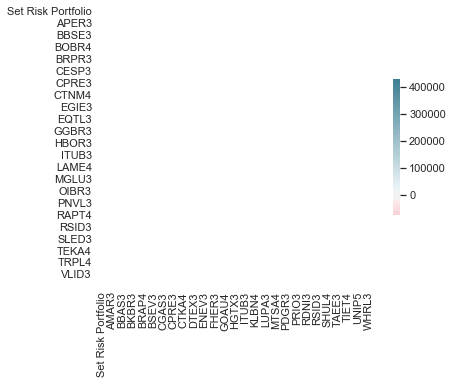

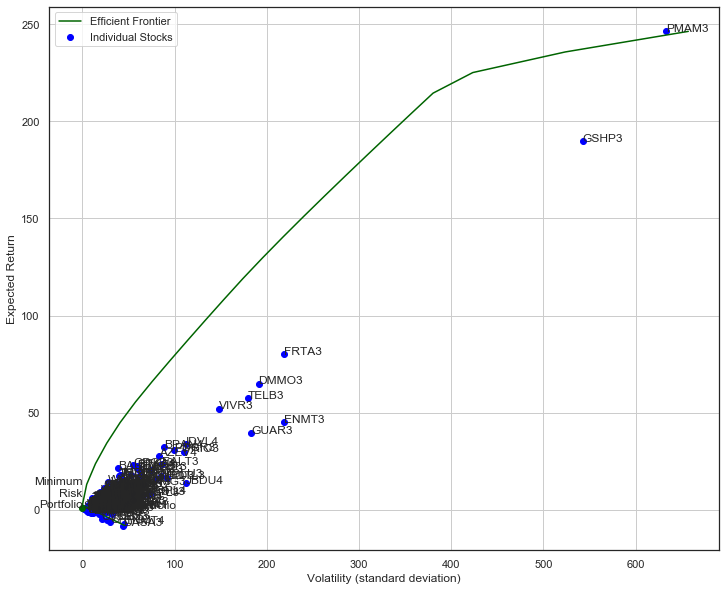

,Set Risk Portfolio
Set Risk Portfolio,0.010000
ABCB4,0.010000
BAHI3,0.087428
BIDI4,0.036965
BOBR4,0.010000
CEBR6,0.036508
CESP3,0.116932
CGRA4,0.010000
CMIG3,0.010000
CPLE6,0.010000


In [28]:
model_ibo_fix = InvestorOpt(dataframe=data_ibo_fix.iloc[:,:], min_allocation=0.01, use_model_for_risk = False)
print('MAX:', model_ibo_fix.get_max_return())
print('MIN:', model_ibo_fix.get_min_return())
model_ibo_fix.get_formatted_cov()
df_alocacao_ibo_fix = model_ibo_fix.plot_efficient_frontier(0.85)
df_alocacao_ibo_fix.loc[df_alocacao_ibo_fix['Set Risk Portfolio']>0]